In [206]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     cross_val_predict, GridSearchCV, RandomizedSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer

# Data Preprocessing

Data from Kaggle (https://www.kaggle.com/blastchar/telco-customer-churn)

In [207]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [208]:
# check out balance of the dependent series "Churn"
df.groupby("Churn").size()

Churn
No     5174
Yes    1869
dtype: int64

In [212]:
5174/(5174+1869), 1869/(5174+1869)

(0.7346301292063041, 0.2653698707936959)

# Data Summary

In [209]:
from pandas_profiling import ProfileReport
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [210]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Cleaning

1. Convert binary features to 1 and 0
2. Apply one-hot encoding on categorical features.

We noticed from the report that gender is not correlated with churn.

In [32]:
new_df = df.drop(["gender", "customerID"], axis=1).replace("", None).dropna()

In [33]:
# select binary features and replace them with boolean
# check if the column has just 2 unique values (i.e. binary feature)

for c in new_df.columns:
    if new_df[c].nunique() == 2:
        new_df[c] = new_df[c].replace("Yes",True).replace("No", False)
new_df.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,True,False,1,False,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,0,False,False,34,True,No,DSL,Yes,No,Yes,No,No,No,One year,False,Mailed check,56.95,1889.5,False
2,0,False,False,2,True,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,0,False,False,45,False,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,0,False,False,2,True,No,Fiber optic,No,No,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True


In [34]:
def convert2flt(value):
    try:
        return float(value)
    except ValueError:
        return None

In [35]:
new_df["TotalCharges"] = new_df["TotalCharges"].apply(convert2flt)

In [36]:
clean_data = pd.get_dummies(new_df)
len_before_dropna = len(clean_data)
clean_data = clean_data.dropna()
print(f"Dropped {len_before_dropna - len(clean_data)} rows.")

Dropped 11 rows.


In [213]:
# Features
X = clean_data.drop("Churn", axis=1)
y = clean_data.Churn
X.shape, y.shape

((7032, 39), (7032,))

# 1. DECISION TREE CLASSIFIER

# Cost complexity pruning 

In [214]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(random_state=42)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impuritiy vs. effective Alpha for training set')

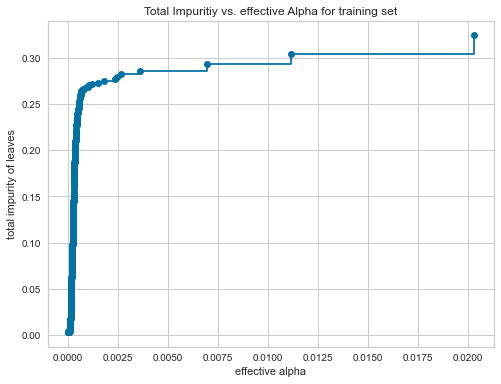

In [215]:
# maximum effective alpha value is removed because it is the 
# trivial tree with only one node remaining after pruning

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle='steps-post')
ax.set_xlabel('effective alpha')
ax.set_ylabel('total impurity of leaves')
ax.set_title("Total Impuritiy vs. effective Alpha for training set")

In [217]:
# train the decision tree using the effective alphas
clfs = []

for aa in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=aa)
    clf.fit(X_train, y_train)
    clfs.append(clf)
    
print(
    f"Number of nodes in the last tree is: {clfs[-1].tree_.node_count} with ccp_alpha: {ccp_alphas[-1]}")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06601746104140926


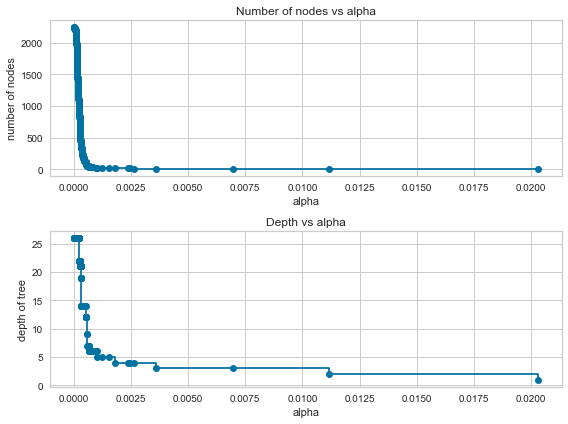

In [218]:
# show how the number of tree depth and nodes decrease as alpha increases

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(figsize=(8,6), nrows=2, ncols=1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle='steps-post')
ax[0].set_xlabel('alpha')
ax[0].set_ylabel('number of nodes')
ax[0].set_title('Number of nodes vs alpha')
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [220]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

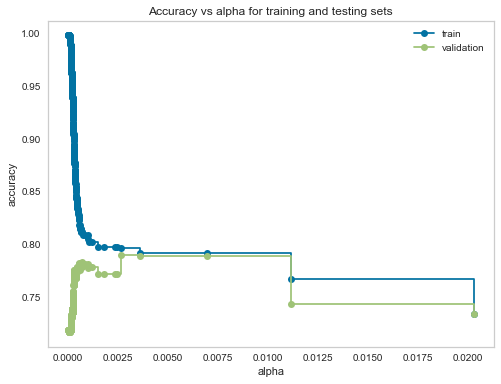

In [221]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()
ax.grid(False)
plt.show()

# Baseline Decision Tree
This DT is un-balanced and un-pruned. This will act as a baseline for more improved versions of the tree

In [39]:
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.81      0.80      0.81      1033
        True       0.47      0.49      0.48       374

    accuracy                           0.72      1407
   macro avg       0.64      0.65      0.64      1407
weighted avg       0.72      0.72      0.72      1407



In [40]:
Counter(y_train)

Counter({True: 1495, False: 4130})

# Balanced weight DTree

In [41]:
baseline_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.80      0.81      1033
        True       0.48      0.50      0.49       374

    accuracy                           0.72      1407
   macro avg       0.65      0.65      0.65      1407
weighted avg       0.73      0.72      0.72      1407



# Oversample minority class in the training dataset

In [42]:
oversampler = SMOTE(n_jobs=-1)

X_train, y_train = oversampler.fit_resample(X_train, y_train)

Counter(y_train)

Counter({True: 4130, False: 4130})

In [43]:
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.82      0.81      0.82      1033
        True       0.50      0.52      0.51       374

    accuracy                           0.73      1407
   macro avg       0.66      0.66      0.66      1407
weighted avg       0.74      0.73      0.73      1407



# Hyper parameter Tuning

1.Using resampled training set to oversample minority class

The key hyperparameters in a DTree are 
* max_leaf_node,
* max_features,
* max_depth,
* min_samples_leaf,
* and ccp_alpha

In [44]:
# Number of features to consider at every split
max_features = [round(i, 2) for i in np.linspace(start=0.1, stop=1.0, num=5)]

# Max depth of the tree
max_depth = [round(x, 2) for x in np.linspace(start=2, stop=20, num=2)]

# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(start=50, stop=600, num=20)]

# Maximum leaves at each node
max_leaf_nodes = [int(x) for x in np.linspace(start=100, stop=500, num=20)]

# Cost complexity penalty (pruning)
ccp_alpha = [round(x, 4) for x in np.linspace(start=0.001, stop=0.05, num=100)]


param_grid = {'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_leaf': min_samples_leaf,
              'max_leaf_nodes': max_leaf_nodes,
              'ccp_alpha': ccp_alpha
              }


In [45]:
dtree = DecisionTreeClassifier()

dt_random = RandomizedSearchCV(estimator=dtree,
                              param_distributions=param_grid,
                              n_iter=50,
                              random_state=42,
                              cv=10
                              )

# fit model
dt_random.fit(X_train, y_train)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions={'ccp_alpha': [0.001, 0.0015, 0.002,
                                                      0.0025, 0.003, 0.0035,
                                                      0.004, 0.0045, 0.005,
                                                      0.0055, 0.0059, 0.0064,
                                                      0.0069, 0.0074, 0.0079,
                                                      0.0084, 0.0089, 0.0094,
                                                      0.0099, 0.0104, 0.0109,
                                                      0.0114, 0.0119, 0.0124,
                                                      0.0129, 0.0134, 0.0139,
                                                      0.0144, 0.0149, 0.0154, ...],
                                        'max_depth': [2.0, 20.0],
                                        'max_features': [0.1, 0.32, 0.55, 0.78,


In [46]:
best_params = dt_random.best_params_
best_params

{'min_samples_leaf': 368,
 'max_leaf_nodes': 457,
 'max_features': 0.78,
 'max_depth': 20.0,
 'ccp_alpha': 0.0045}

# Validation Curve

In [83]:
from yellowbrick.model_selection import ValidationCurve, LearningCurve
import seaborn as sns
sns.set_style('whitegrid')

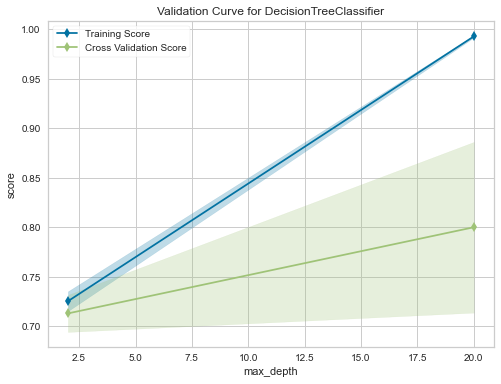

<Figure size 432x288 with 0 Axes>

In [196]:
fig, ax = plt.subplots(figsize=(8,6))
val_curve = ValidationCurve(DecisionTreeClassifier(),
                            param_name='max_depth',
                           param_range=max_depth,
                           scoring='accuracy',
                           n_jobs=-1,
                            cv=5,
                           ax=ax)

val_curve.fit(X_train, y_train)
val_curve.poof()
sns.despine()
fig.tight_layout();

# Learning Curve

In [49]:
best_params

{'min_samples_leaf': 368,
 'max_leaf_nodes': 457,
 'max_features': 0.78,
 'max_depth': 20.0,
 'ccp_alpha': 0.0045}

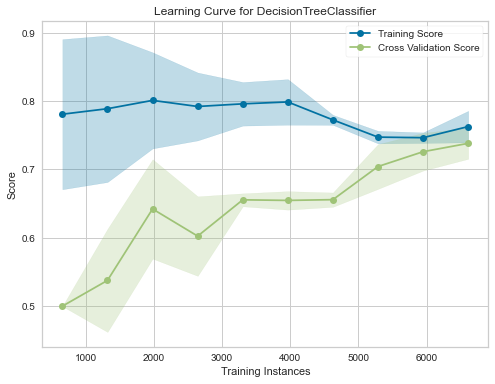

<Figure size 432x288 with 0 Axes>

In [197]:
fig, ax = plt.subplots(figsize=(8,6))
learn_curve = LearningCurve(dt_random.best_estimator_,
                           train_sizes=np.arange(.1, 1.01, .1),
                           scoring='accuracy',
                           cv=5,
                           ax=ax)

learn_curve.fit(X_train, y_train)
learn_curve.poof()
sns.despine()
fig.tight_layout();

# Final model prediction

In [52]:
best_params

{'min_samples_leaf': 368,
 'max_leaf_nodes': 457,
 'max_features': 0.78,
 'max_depth': 20.0,
 'ccp_alpha': 0.0045}

In [54]:
model = dt_random.best_estimator_

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 29.1 ms, sys: 3.98 ms, total: 33.1 ms
Wall time: 31.7 ms
CPU times: user 4.05 ms, sys: 616 µs, total: 4.66 ms
Wall time: 4.68 ms
              precision    recall  f1-score   support

       False       0.87      0.70      0.78      1033
        True       0.46      0.71      0.56       374

    accuracy                           0.71      1407
   macro avg       0.67      0.71      0.67      1407
weighted avg       0.76      0.71      0.72      1407



# K-fold Cross Validation (Generalization Error)

In [223]:
cv_score = cross_val_score(estimator=dt_random.best_estimator_,
                          X=X_train,
                          y=y_train,
                          cv=10,
                          n_jobs=-1,
                          verbose=1)

print(cv_score)
print('-'*20)
"Accuracy: %.3f%% (%.3f%%)" % (cv_score.mean()*100.0, cv_score.std()*100.0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[0.74955595 0.79751332 0.78330373 0.79573712 0.75310835 0.8024911
 0.76868327 0.79003559 0.78291815 0.8113879 ]
--------------------


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.2s finished


'Accuracy: 78.347% (1.955%)'

# Performance Metrics

In [194]:
from sklearn.model_selection import cross_val_predict
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import (classification_report,
                             accuracy_score,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             precision_recall_curve)

In [195]:
y_score = cross_val_predict(model, X=X, y=y,
                           cv=5, method='predict_proba')[:,1]

pred_scores = dict(y_true=y, y_score=y_score)

# ROC AUC

roc_auc_score(**pred_scores)

0.8082665614607457

In [65]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [66]:
# Precision-Recall
precision, recall, threshold = precision_recall_curve(y_true=y, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision':precision, 'Recall':recall})

In [67]:
# F1-score
f1 = pd.Series({t: f1_score(y_true=y, y_pred=y_score>t) for t in threshold})
best_threshold = f1.idxmax()

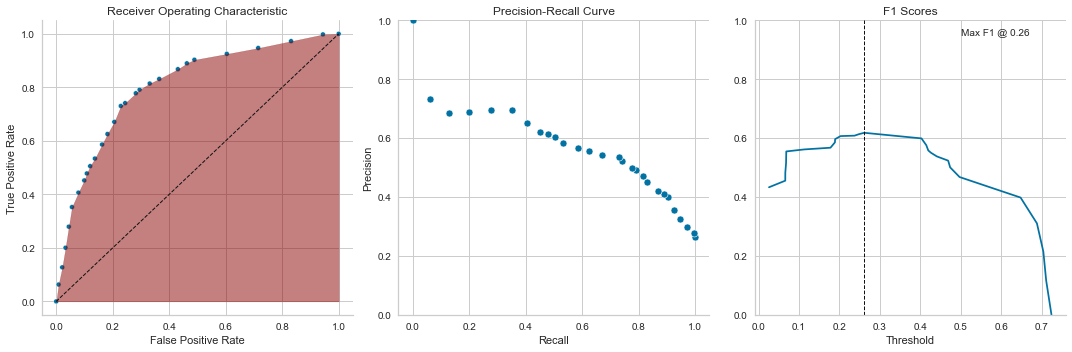

In [68]:
# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

# 2. DECISION TREE CLASSIFIER WITH adaBOOST

In [69]:
from sklearn.ensemble import AdaBoostClassifier

## Hyperparameter tuning

In [162]:
# Grid Search AdaBoost
param_grid = {'n_estimators': [int(x)for x in np.linspace(1, 50, 10)]}

ada = AdaBoostClassifier(
                base_estimator = dt_random.best_estimator_,
                n_estimators = 50,
                random_state = 42
            )

ada_rcv = GridSearchCV(estimator=ada,
                              param_grid=param_grid,
                              cv=5,
                              n_jobs=8
                              )

# fit model
ada_rcv.fit(X_train, y_train)
# extract best params
best_params = ada_rcv.best_params_
best_params

{'n_estimators': 17}

# Validation Curve

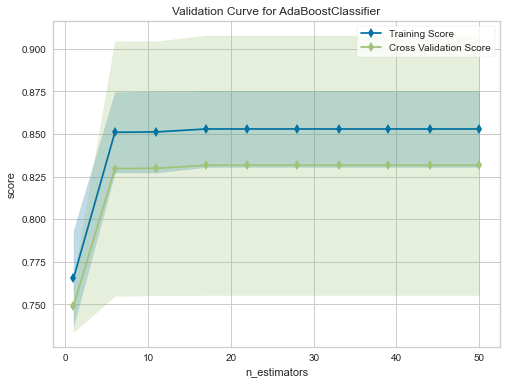

<Figure size 432x288 with 0 Axes>

In [198]:
n_estimators = [int(x) for x in np.linspace(start=1, stop=50, num=10)]

fig, ax = plt.subplots(figsize=(8, 6))
val_curve_2 = ValidationCurve(ada,
                      param_name='n_estimators',
                      param_range=n_estimators,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1,
                      ax=ax)
val_curve_2.fit(X_train, y_train)
val_curve_2.poof()
sns.despine()
fig.tight_layout();

# Learning Curve

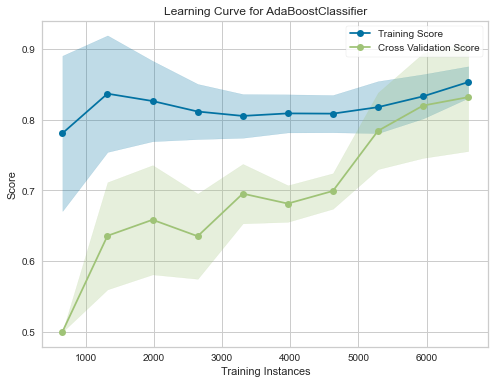

<Figure size 432x288 with 0 Axes>

In [199]:
fig, ax = plt.subplots(figsize=(8,6))
learn_curve = LearningCurve(ada,
                           train_sizes=np.arange(.1, 1.01, .1),
                           scoring='accuracy',
                           cv=5,
                           ax=ax)

learn_curve.fit(X_train, y_train)
learn_curve.poof()
sns.despine()
fig.tight_layout();

# Final model prediction

In [90]:
# Define the AdaBoost model
ada_boost = AdaBoostClassifier(
                base_estimator = dt_random.best_estimator_,
                n_estimators = 17,
                random_state = 42
            )

In [91]:
%time ada_boost.fit(X_train, y_train)

CPU times: user 504 ms, sys: 4.44 ms, total: 508 ms
Wall time: 508 ms


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0045,
                                                         max_depth=20.0,
                                                         max_features=0.78,
                                                         max_leaf_nodes=457,
                                                         min_samples_leaf=368),
                   n_estimators=17, random_state=42)

In [92]:
%time y_pred = ada_boost.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 32.8 ms, sys: 1.41 ms, total: 34.2 ms
Wall time: 33.3 ms
              precision    recall  f1-score   support

       False       0.85      0.85      0.85      1033
        True       0.59      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



In [ ]:
# report from optimized  DTree 
  precision    recall  f1-score   support

       False       0.85      0.72      0.78      1033
        True       0.46      0.65      0.54       374

    accuracy                           0.70      1407
   macro avg       0.66      0.69      0.66      1407
weighted avg       0.75      0.70      0.72      1407

# K-fold Cross Validation (Generalization Error)

In [155]:
kf = KFold(n_splits=10, shuffle=True)
kf.split(X_train)

<generator object _BaseKFold.split at 0x24c9930b0>

In [156]:
scores = cross_val_score(ada_boost, X_train, y_train, cv=kf.split(X_train))
print(scores)

[0.83656174 0.83171913 0.83414044 0.84624697 0.85714286 0.83535109
 0.8401937  0.8401937  0.8559322  0.86803874]


In [157]:
print(f"Accuracy {(scores.mean()*100.0, scores.std()*100.0)}")

Accuracy (84.45520581113801, 1.14110137219837)


In [158]:
y_score = cross_val_predict(ada_boost, X=X, y=y,
                           cv=5, method='predict_proba')[:,1]

pred_scores = dict(y_true=y, y_score=y_score)

In [159]:
# ROC_AUC
roc_auc_score(**pred_scores)

0.831746280459793

In [160]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [161]:
# Precision-Recall
precision, recall, threshold = precision_recall_curve(y_true=y, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision':precision, 'Recall':recall})

In [162]:
# F1-score
f1 = pd.Series({t: f1_score(y_true=y, y_pred=y_score>t) for t in threshold})
best_threshold = f1.idxmax()

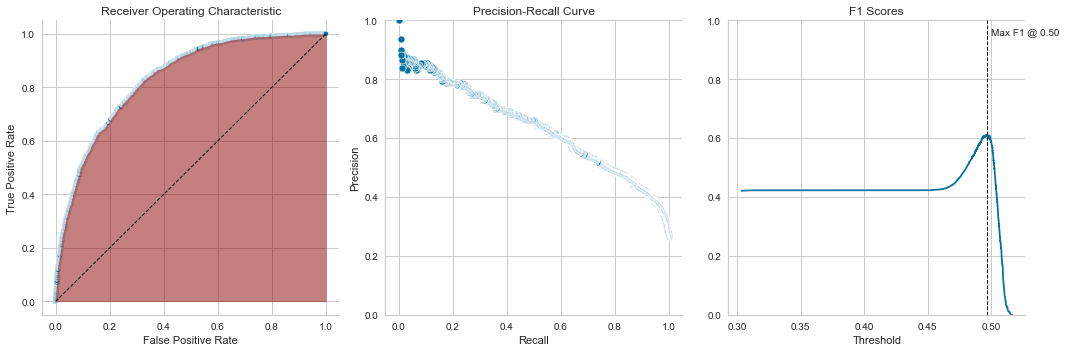

In [163]:
# Plot
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

   # 3. k-NN CLASSIFIER

In [93]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# Hyper-parameter tuning

In [95]:

pipe = Pipeline([('scaler', StandardScaler()), 
                 ('knn', KNeighborsClassifier())])

param_grid = {
    'knn__metric': ['minkowski', 'euclidean','manhattan'],
    'knn__n_neighbors': tuple(range(5, 101, 10)),
    'knn__weights': ['uniform','distance'],
    'knn__p': [1,2]
}

estimator_knn = GridSearchCV(estimator=pipe,
                        param_grid=param_grid,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=-1)

%time estimator_knn.fit(X=X_train, y=y_train)

CPU times: user 2.34 s, sys: 307 ms, total: 2.65 s
Wall time: 1min 10s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['minkowski', 'euclidean', 'manhattan'],
                         'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95),
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='roc_auc')

In [97]:
estimator_knn.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=35, p=1,
                                      weights='distance'))])

In [98]:
estimator_knn.best_params_ # uses manhattan distance

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 35,
 'knn__p': 1,
 'knn__weights': 'distance'}

# Validation Curve

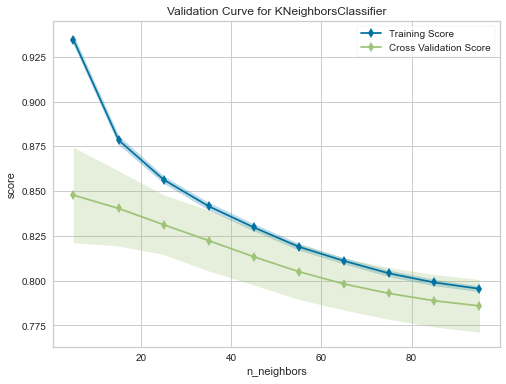

<Figure size 432x288 with 0 Axes>

In [100]:
n_neighbors = tuple(range(5, 101, 10))
fig, ax = plt.subplots(figsize=(8, 6))
val_curve = ValidationCurve(KNeighborsClassifier(),
                      param_name='n_neighbors',
                      param_range=n_neighbors,
                      cv=10,
                      scoring='roc_auc',
                      n_jobs=-1,
                      ax=ax)
val_curve.fit(X_train, y_train)
val_curve.poof()
sns.despine()
fig.tight_layout();

# Learning Curve

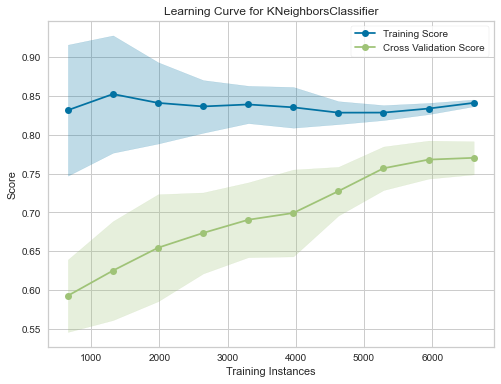

<Figure size 432x288 with 0 Axes>

In [201]:
fig, ax = plt.subplots(figsize=(8,6))
learn_curve = LearningCurve(KNeighborsClassifier(),
                           train_sizes=np.arange(.1, 1.01, .1),
                           scoring='accuracy',
                           cv=5,
                           ax=ax)

learn_curve.fit(X_train, y_train)
learn_curve.poof()
sns.despine()
fig.tight_layout();

# Final model prediction

In [116]:
knn_model = estimator_knn.best_estimator_

%time knn_model.fit(X_train, y_train)
%time y_pred = knn_model.predict(X_test)
print(classification_report(y_test, y_pred))

CPU times: user 106 ms, sys: 8.36 ms, total: 115 ms
Wall time: 136 ms
CPU times: user 1.29 s, sys: 149 ms, total: 1.44 s
Wall time: 1.61 s
              precision    recall  f1-score   support

       False       0.86      0.78      0.82      1033
        True       0.52      0.65      0.58       374

    accuracy                           0.75      1407
   macro avg       0.69      0.72      0.70      1407
weighted avg       0.77      0.75      0.76      1407



# K-fold Cross Validation (Generalization Error)

In [226]:
cv_score = cross_val_score(estimator=knn_model,
                          X=ss.fit_transform(X_train),
                          y=y_train,
                          cv=10,
                          n_jobs=-1,
                          verbose=1)

print(cv_score)
print('-'*20)
"Accuracy: %.3f%% (%.3f%%)" % (cv_score.mean()*100.0, cv_score.std()*100.0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


[0.77975133 0.77975133 0.76731794 0.77442274 0.74067496 0.79003559
 0.77758007 0.77758007 0.79359431 0.8024911 ]
--------------------


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.4s finished


'Accuracy: 77.832% (1.585%)'

#    Performance metrics

# ROC_AUC

In [118]:

y_score = cross_val_predict(knn_model, X=X, y=y,
                           cv=5, method='predict_proba')[:,1]

pred_scores = dict(y_true=y, y_score=y_score)

roc_auc_score(**pred_scores)

0.8049555595142496

In [119]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

# Precision-Recall

In [120]:
precision, recall, threshold = precision_recall_curve(y_true=y, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision':precision, 'Recall':recall})

# F1-score

In [121]:
f1 = pd.Series({t: f1_score(y_true=y, y_pred=y_score>t) for t in threshold})
best_threshold = f1.idxmax()

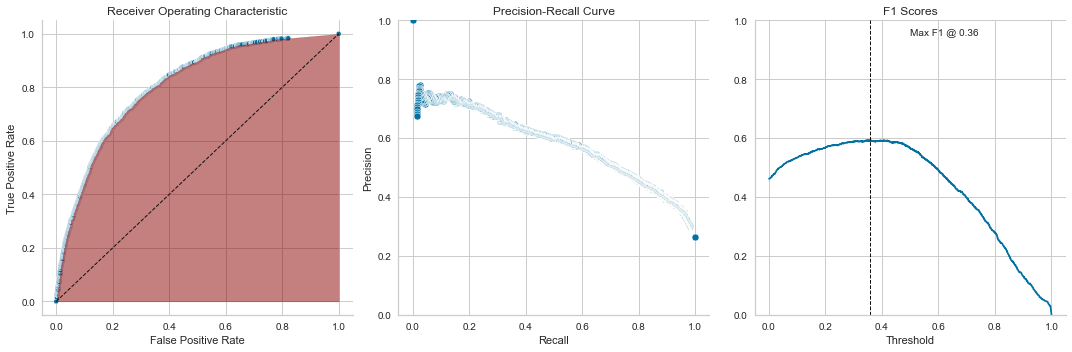

In [122]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();

# 4. SVM

# Hyper-parameter tuning

In [123]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [124]:
steps = [('scaler', StandardScaler()), ('svc', SVC())]
pipeline = Pipeline(steps)

## Radial Basis Function (Gaussian)  kernel

In [125]:
# test the different input for C and gamma
# C <-- the regularization parameter (trade-off between error and decision boundary)
# gamma <-- determines how far the influence of a single training example reaches 
C = [1e1, 1e2, 1e3, 1e4, 1e5]
gamma = [1e-3, 1e-2, 1e-1, 1e0]

# Initialize parameters
parameters = {'svc__C': C,
             'svc__gamma': gamma,
             'svc__kernel': ['rbf']
             }

rbf_rcv = RandomizedSearchCV(estimator=pipeline,
                        param_distributions=parameters,
                        cv=5,
                        n_jobs=-1)

# Training on and fetching the best parameters
rbf_rcv.fit(X_train, y_train)

# Obtain the best parameters of C
best_C = rbf_rcv.best_params_['svc__C']

# Obtain the best parameters of kernel
best_kernel = rbf_rcv.best_params_['svc__kernel']

# Obtain the best parameters of gamma
best_gamma = rbf_rcv.best_params_['svc__gamma']

In [126]:
rbf_rcv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc', SVC(C=100.0, gamma=0.001))])

# Validation Curve

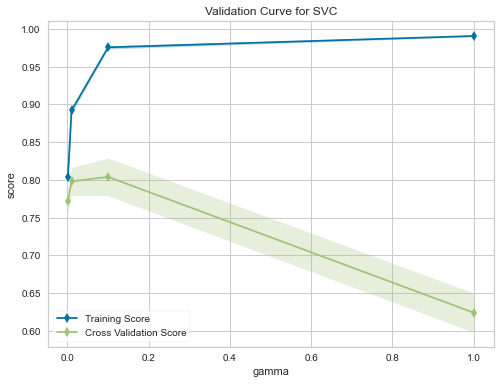

<Figure size 432x288 with 0 Axes>

In [203]:
# Varying gamma
fig, ax = plt.subplots(figsize=(8, 6))
val_curve_1 = ValidationCurve(SVC(),
                      param_name='gamma',
                      param_range=gamma,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=-1,
                      ax=ax)
val_curve_1.fit(X_train, y_train)
val_curve_1.poof()
sns.despine()
fig.tight_layout();

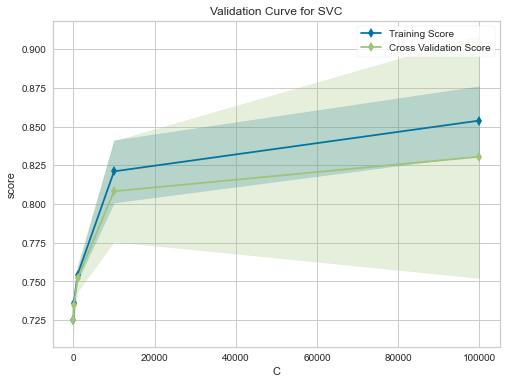

<Figure size 432x288 with 0 Axes>

In [204]:
# Varying C
fig, ax = plt.subplots(figsize=(8, 6))
val_curve_2 = ValidationCurve(SVC(),
                      param_name='C',
                      param_range=C,
                      cv=5,
                      scoring='accuracy',
                      n_jobs=2,
                      ax=ax)
val_curve_2.fit(X_train, y_train)
val_curve_2.poof()
sns.despine()
fig.tight_layout();

# Learning Curve

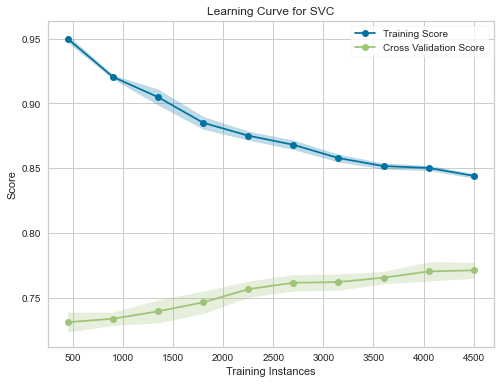

<Figure size 432x288 with 0 Axes>

In [222]:
fig, ax = plt.subplots(figsize=(8, 6))
l_curve = LearningCurve(SVC(probability=True), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring='accuracy', 
                        cv=5, 
                        n_jobs=8,
                        ax=ax)
l_curve.fit(X_train, y_train)
l_curve.poof()
sns.despine()
fig.tight_layout();

# Final model prediction

In [133]:
# create SVC with the optimized hyperparameters from gridsearch
svc_model = SVC(C=best_C, kernel=best_kernel, gamma=best_gamma, probability=True)
ss = StandardScaler().fit(X_train)

# Pass the scaled train data to the SVC classifier
%time svc_model.fit(ss.fit_transform(X_train), y_train)

# Pass the test data to the predict function 
%time y_pred = svc_model.predict(ss.transform(X_test))
print(classification_report(y_test, y_pred))

CPU times: user 27.4 s, sys: 432 ms, total: 27.9 s
Wall time: 31.2 s
CPU times: user 1.62 s, sys: 15.6 ms, total: 1.64 s
Wall time: 1.72 s
              precision    recall  f1-score   support

       False       0.84      0.87      0.86      1033
        True       0.61      0.54      0.57       374

    accuracy                           0.79      1407
   macro avg       0.72      0.71      0.71      1407
weighted avg       0.78      0.79      0.78      1407



# K-fold Cross Validation (Generalization Error)

In [134]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, shuffle=True)
kf.split(ss.transform(X_train))

scores = cross_val_score(svc_model, ss.transform(X_train), y_train, cv=kf.split(ss.transform(X_train)))
print(scores)
print('-'*20)
"Accuracy: %.3f%% (%.3f%%)" % (scores.mean()*100.0, scores.std()*100.0)

[0.86198547 0.85472155 0.84987893 0.85714286 0.84987893 0.86319613
 0.84382567 0.82566586 0.84261501 0.85472155]
--------------------


'Accuracy: 85.036% (1.047%)'

# Performance metrics

# ROC_AUC

In [135]:
y_score = cross_val_predict(svc_model, X=ss.transform(X), y=y,
                           cv=5, method='predict_proba')[:,1]

pred_scores = dict(y_true=y, y_score=y_score)

roc_auc_score(**pred_scores)

0.8124934000176379

# Precision and Recall

In [136]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

precision, recall, threshold = precision_recall_curve(y_true=y, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision':precision, 'Recall':recall})

# F1-score

In [137]:
f1 = pd.Series({t: f1_score(y_true=y, y_pred=y_score>t) for t in threshold})
best_threshold = f1.idxmax()

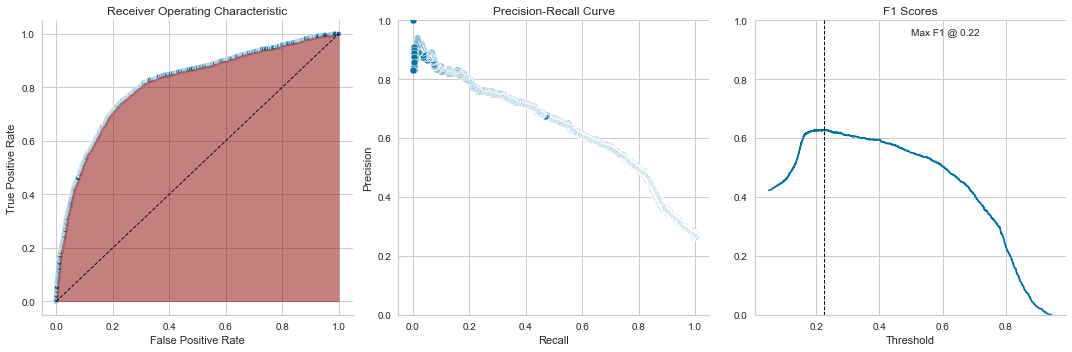

In [138]:
import seaborn as sns
sns.set_style('whitegrid')

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();



# 5. Neural Networks (MLP)

## Hyper-parameter tuning

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from itertools import product

In [140]:
steps = [('scaler', StandardScaler()), ('mlp', MLPClassifier(random_state=42))]
pipeline = Pipeline(steps)
ss = StandardScaler().fit(X_train)

# Initialize parameters

parameters = {
    # 'mlp__hidden_layer_sizes': [x for x in product((20,30,40,50,100),repeat=3)],
    'mlp__hidden_layer_sizes': [(40, 30, 100), (40, 30, 40), (30, 20, 30), (20, 20, 20, 10)],
    'mlp__activation': ['tanh', 'relu', 'logistic'],
    'mlp__solver': ['sgd', 'adam', 'lbfgs'],
    'mlp__alpha': [0.0001,0.001,0.01, 0.05],
    'mlp__learning_rate': ['constant','adaptive'],
    'mlp__early_stopping':[True, False] }

mlp_gcv = GridSearchCV(estimator=pipeline,
                        param_grid=parameters,
                        cv=5,
                        scoring='roc_auc',
                        n_jobs=8)

# Training on and fetching the best parameters
mlp_gcv.fit(ss.transform(X_train), y_train)

# Obtain the best parameters
best_hidden_layer_sizes = mlp_gcv.best_params_['mlp__hidden_layer_sizes']
best_activation = mlp_gcv.best_params_['mlp__activation']
best_solver = mlp_gcv.best_params_['mlp__solver']
best_alpha = mlp_gcv.best_params_['mlp__alpha']
best_learning_rate = mlp_gcv.best_params_['mlp__learning_rate']

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/s

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-l

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

In [ ]:
# best_params_ = {'mlp__activation': 'logistic',
#                  'mlp__alpha': 0.01,
#                  'mlp__early_stopping': False,
#                  'mlp__hidden_layer_sizes': (50, 100, 50),
#                  'mlp__learning_rate': 'constant',
#                  'mlp__solver': 'adam'}

# Validation Curve

In [31]:
from yellowbrick.model_selection import ValidationCurve, LearningCurve
import seaborn as sns
sns.set_style('whitegrid')

In [181]:
mlp_gcv.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(activation='logistic', alpha=0.01,
                               hidden_layer_sizes=(30, 20, 30),
                               random_state=42))])

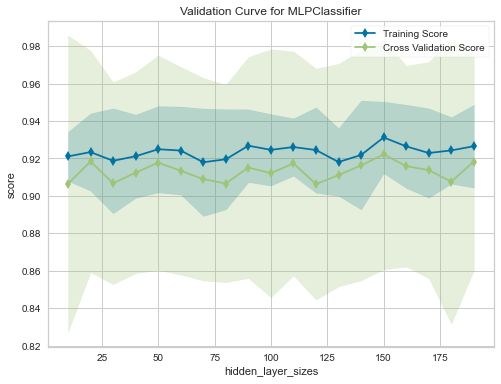

<Figure size 432x288 with 0 Axes>

In [183]:
# Varying hidden_layer_sizes
fig, ax = plt.subplots(figsize=(8, 6))
val_curve_1 = ValidationCurve(MLPClassifier(random_state=42,
                                           activation='logistic',
                                           alpha=0.01),
                      param_name='hidden_layer_sizes',
                      param_range=np.arange(10,200,10),
                      cv=5,
                      scoring='roc_auc',
                      n_jobs=-1,
                      ax=ax)
val_curve_1.fit(X_train, y_train)
val_curve_1.poof()
sns.despine()
fig.tight_layout();

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (4) reached and the optimization hasn't converged yet.
  warnings.warn(


/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (34) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (35) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (36) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (37) reached and the optimization hasn't converged yet.
  warnings.wa

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (21) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.wa

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.wa

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (38) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  warnings.warn

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (22) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (23) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (24) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.wa

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (45) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (11) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (12) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (46) reached and the optimization hasn't converged yet.
  warnings.wa

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (39) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (41) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (42) reached and the optimization hasn't converged yet.
  warnings.wa

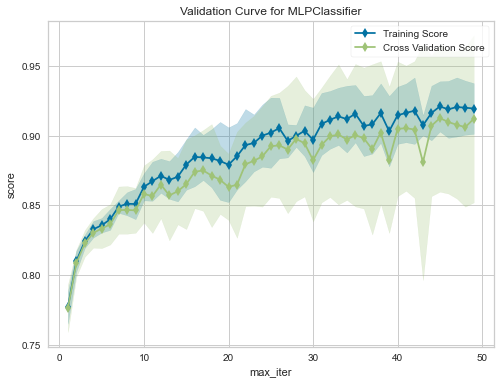

<Figure size 432x288 with 0 Axes>

In [184]:
fig, ax = plt.subplots(figsize=(8, 6))
val_curve_2 = ValidationCurve(MLPClassifier(random_state=42,
                                           activation='logistic',
                                           alpha=0.01),
                      param_name='max_iter',
                      param_range=np.arange(1,50),
                      cv=5,
                      scoring='roc_auc',
                      n_jobs=-1,
                      ax=ax)
val_curve_2.fit(X_train, y_train)
val_curve_2.poof()
sns.despine()
fig.tight_layout();

# Learning Curve

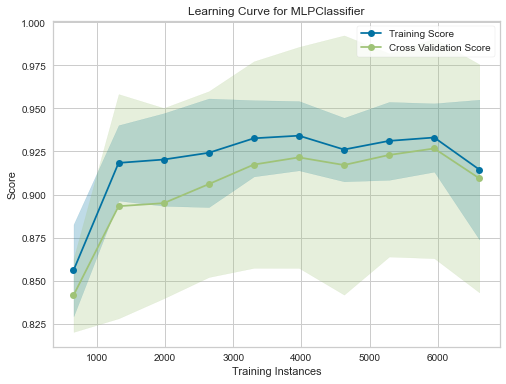

<Figure size 432x288 with 0 Axes>

In [185]:
fig, ax = plt.subplots(figsize=(8, 6))
l_curve = LearningCurve(MLPClassifier(activation='logistic',
                                     alpha=0.01,
                                     early_stopping=False,
                                     hidden_layer_sizes=(50, 100, 50),
                                     learning_rate='constant',
                                     solver='adam'), 
                        train_sizes=np.arange(.1, 1.01, .1),
                        scoring='roc_auc', 
                        cv=5, 
                        n_jobs=8,
                        ax=ax)
l_curve.fit(X_train, y_train)
l_curve.poof()
sns.despine()
fig.tight_layout();

## Training (loss) curve

0.8108353510895884


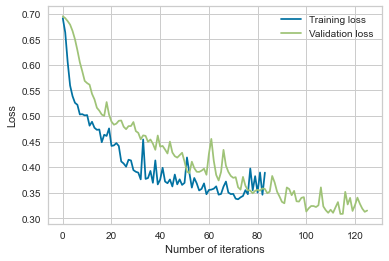

In [189]:
mlp = MLPClassifier(activation='logistic',
                     alpha=0.01,early_stopping=False,
                     hidden_layer_sizes=(50, 100, 50),
                     learning_rate='constant',
                     solver='adam',
                    max_iter=200)

# re-split training data into traing and validation set
t = .8
split = int(t*len(X_train))
X_tr,X_val,y_tr,y_val=train_test_split(X_train, y_train, test_size=0.2, random_state=42)


mlp.fit(X_tr, y_tr)
print(mlp.score(X_tr, y_tr))
plt.plot(mlp.loss_curve_, label='Training loss')
mlp.fit(X_val, y_val)
plt.plot(mlp.loss_curve_,label='Validation loss')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Final model prediction

In [35]:
# best_params_ = {'mlp__activation': 'logistic',
#                  'mlp__alpha': 0.01,
#                  'mlp__early_stopping': False,
#                  'mlp__hidden_layer_sizes': (50, 100, 50),
#                  'mlp__learning_rate': 'constant',
#                  'mlp__solver': 'adam'}

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 ])

In [190]:
# create MLP with the optimized hyperparameters from gridsearch
mlp_model = MLPClassifier(activation='logistic',
                                     alpha=0.01,
                                     early_stopping=False,
                                     hidden_layer_sizes=(50, 100, 50),
                                     learning_rate='constant',
                                     solver='adam')
ss = StandardScaler().fit(X_train)

# Pass the scaled train data to the MLP classifier
%time mlp_model.fit(ss.fit_transform(X_train), y_train)

# Pass the test data to the predict function 
%time y_pred = mlp_model.predict(ss.transform(X_test))
print(classification_report(y_test, y_pred))

CPU times: user 1min 23s, sys: 3.78 s, total: 1min 27s
Wall time: 7.96 s
CPU times: user 126 ms, sys: 18 ms, total: 144 ms
Wall time: 13.5 ms
              precision    recall  f1-score   support

       False       0.85      0.85      0.85      1033
        True       0.58      0.60      0.59       374

    accuracy                           0.78      1407
   macro avg       0.72      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



## k-Fold Cross Validation (Generalization error)

In [227]:
cv_score = cross_val_score(estimator=mlp_model,
                          X=ss.fit_transform(X_train),
                          y=y_train,
                          cv=10,
                          n_jobs=-1,
                          verbose=1)

print(cv_score)
print('-'*20)
"Accuracy: %.3f%% (%.3f%%)" % (cv_score.mean()*100.0, cv_score.std()*100.0)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum 

[0.79218472 0.79928952 0.77975133 0.80461812 0.74777975 0.80071174
 0.77580071 0.79893238 0.79715302 0.81672598]
--------------------


'Accuracy: 79.129% (1.827%)'

# Performance Metrics

In [48]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             roc_auc_score,
                             roc_curve,
                             f1_score,
                             precision_recall_curve)

# ROC_AUC

In [49]:
y_score = cross_val_predict(mlp_model, X=ss.transform(X), y=y,
                           cv=5, method='predict_proba')[:,1]

pred_scores = dict(y_true=y, y_score=y_score)

roc_auc_score(**pred_scores)

/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/anaconda3/envs/quantra_py/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

0.8338819544383334

# Precision and Recall

In [50]:
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

precision, recall, threshold = precision_recall_curve(y_true=y, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision':precision, 'Recall':recall})

# F1-score

In [51]:
f1 = pd.Series({t: f1_score(y_true=y, y_pred=y_score>t) for t in threshold})
best_threshold = f1.idxmax()

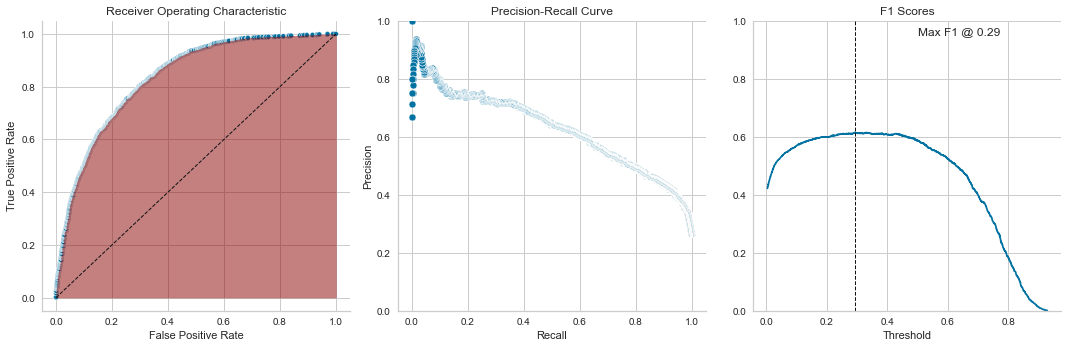

In [52]:
import seaborn as sns
sns.set_style('whitegrid')

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc, size=5, legend=False, ax=axes[0])
axes[0].plot(np.linspace(0,1,100), np.linspace(0,1,100), color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'], x=roc['False Positive Rate'], alpha=.5,color='darkred')
axes[0].set_title('Receiver Operating Characteristic')


sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0,1)
axes[1].set_title('Precision-Recall Curve')


f1.plot(ax=axes[2], title='F1 Scores', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 @ {best_threshold:.2f}', x=.5, y=.95)
sns.despine()
fig.tight_layout();